# Twitter Scraping

## @realDonaldTrump

+ Presidential Announcement: June 16, 2015
+ Presumptive Nominee: May 4, 2016

<img src="trump.jpg">


## Initial Questions


+ How do people feel about Trump? 
+ Has sentiment changed over time?
+ What are the most frequent words tweeted to him?
+ Will this give us an idea of whether he'll win?


## Data
+ Tweets from June 1, 2015 to May 20, 2016
+ 5889 tweets
+ Looked at text, date, location, #, @, retweets, likes

<img src="twitstructure.jpg">

## Scraping Twitter without API

In [ ]:
# Import libraries

from selenium import webdriver
from bs4 import BeautifulSoup
import time
import pymongo
import numpy as np
import pandas as pd


url = "https://twitter.com/search?f=tweets&vertical=default&q=lang%3Aen%20from%3ArealDonaldTrump%20since%3A2015-06-1%20until%3A2016-05-21&src=typd"


# Open webdriver and url
driver = webdriver.Firefox()
driver.get(url)
driver.maximize_window()

# Scroll down to bottom of page
lastHeight = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    newHeight = driver.execute_script("return document.body.scrollHeight")
    if newHeight == lastHeight:
        break
    lastHeight = newHeight

pho = BeautifulSoup(driver.page_source, "html.parser")


# Connect to Mongo DB
try:
    conn = pymongo.MongoClient()
    print "Connected successfully..."
except pymongo.errors.ConnectionFailure, e:
    print "Could not connect to MongoDB: %s" % e
conn

mydb = conn['twits']

# Extract information from url

dat = pd.DataFrame({'time': [], 'twit': [], 'tag': [], 'at': [], \
                    're': [], 'like': [], 'loc': []})

for t in pho.find_all('div', {'class': 'content'}):
    time = t.find('a', {'class': 'tweet-timestamp'})['title'].encode('UTF-8')
    try:
        twit = t.find('p', {'class': 'TweetTextSize'}).text.encode('UTF-8')
    except:
        pass
    tag = []
    for l in t.find_all('a', {'class': 'twitter-hashtag'}):
        tag.append(l.text.encode('UTF-8')[1:])
    if tag == []:
        tag = np.NaN
    at = []
    for a in t.find_all('a', {'class': 'twitter-atreply'}):
        try:
            at.append(a['href'].encode('UTF-8')[1:])
        except:
            pass
    if at == []:
        at = np.NaN
    thumbs = t.find_all('span', \
                        {'class': 'ProfileTweet-actionCountForPresentation'})
    try:
        re = thumbs[0].text.encode('UTF-8')
        if re[-1] == 'K':
            re = int(float(re[:-1].encode('UTF-8')) * 1000)
        else:
            re = int(float(re.encode('UTF-8')))
    except:
        pass
    try:
        like = thumbs[2].text.encode('UTF-8')
        if like[-1] == 'K':
            like = int(float(like[:-1].encode('UTF-8'))*1000)
        else:
            like = int(float(like.encode('UTF-8')))
    except:
        pass
    if t.find_all('span', {'class': 'Tweet-geo'}) == []:
        loc = np.NaN
    else:
        loc = t.find('span', {'class': 'Tweet-geo'})['title'].encode('UTF-8')
    entry = {'time': time, 'twit': twit, 'tag': [tag], 'at': [at], \
             're': re, 'like': like, 'loc': loc}
    dat = dat.append([pd.DataFrame(entry)], ignore_index=True)
    mydb.trump.insert(entry)

# Export as a csv for safekeeping
dat.to_csv('trumptwit.csv', encoding='utf-8')

print "Mission Complete..."
driver.close()
print "Have a nice day!"

In [5]:
# Import remaining libraries
%matplotlib inline
import re
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords") # install nltk
stops = stopwords.words('english')

twits = pd.read_csv('trumptwit.csv', index_col='Unnamed: 0')

## Extracted Data

In [6]:
# Convert time format
twits['time'] = pd.to_datetime(twits['time'], format='%I:%M %p - %d %b %Y')
twits

,at,like,loc,re,tag,time,twit
0,[montgomeriefdn],2800.0,NaN,1000.0,NaN,2016-05-20 16:36:00,"@montgomeriefdn Colin, great to have you at T..."
1,"[montgomeriefdn, TrumpTurnberry]",7500.0,NaN,1800.0,NaN,2016-05-20 16:27:00,"""@montgomeriefdn: @TrumpTurnberry Best Links C..."
2,[TGowdySC],13000.0,NaN,4600.0,[Trump2016],2016-05-20 15:50:00,Thank you for your wonderful endorsement today...
3,[NRA],14000.0,NaN,4400.0,"[MakeAmericaGreatAgain, Trump2016]",2016-05-20 14:55:00,"Great day in Kentucky with Wayne LaPierre, Chr..."
4,"[NRA, GOPconvention]",16000.0,NaN,6600.0,"[Trump2016, 2A, NRA, NRAAM]",2016-05-20 13:06:00,Thank you! An honor to be the first candidate ...
5,[nytimes],12000.0,United States,3600.0,NaN,2016-05-20 09:11:00,Failing @NYTimes will always take a good story...
6,[piersmorgan],15000.0,United States,4700.0,NaN,2016-05-20 09:09:00,"Thanks @piersmorgan! \n""Trump is the most unpr..."
7,[NRA],11000.0,NaN,6300.0,"[SecondAmendment, 2A]",2016-05-20 08:36:00,Crooked Hillary Clinton- discussing the #Secon...
8,NaN,7600.0,"New York, NY",2700.0,[NRAAM],2016-05-20 08:15:00,I am on my way! See you all soon!https://twitt...
9,[JasonDovEsq],6000.0,NaN,2000.0,NaN,2016-05-20 07:30:00,"""A Call for Unity"" by Jason Greenblatt @JasonD..."


In [4]:
twits.count()

at      3659
like    5889
loc      642
re      5889
tag     1344
time    5889
twit    5889
dtype: int64

In [7]:
twits.describe()

,like,re
count,5889.000000,5889.000000
mean,5231.653761,2021.047886
std,6139.156165,2538.561256
min,14.000000,2.000000
25%,1400.000000,626.000000
50%,2900.000000,1200.000000
75%,6900.000000,2600.000000
max,110000.000000,85000.000000


## Location

In [8]:
# location count

location = pd.DataFrame.from_dict(Counter(twits[twits['loc'].notnull()]['loc']), orient='index').reset_index()
location.columns = ['location', 'count']
location = location.sort_values('count', ascending=False)
location.reset_index(drop=True)[:20]

,location,count
0,"Manhattan, NY",356
1,"New Jersey, USA",154
2,"Beverly Hills, CA",16
3,"Queens, NY",15
4,"Doral, FL",11
5,"Nevada, USA",9
6,"Milwaukee, WI",7
7,United States,5
8,Trump Tower,5
9,"Manchester, NH",4


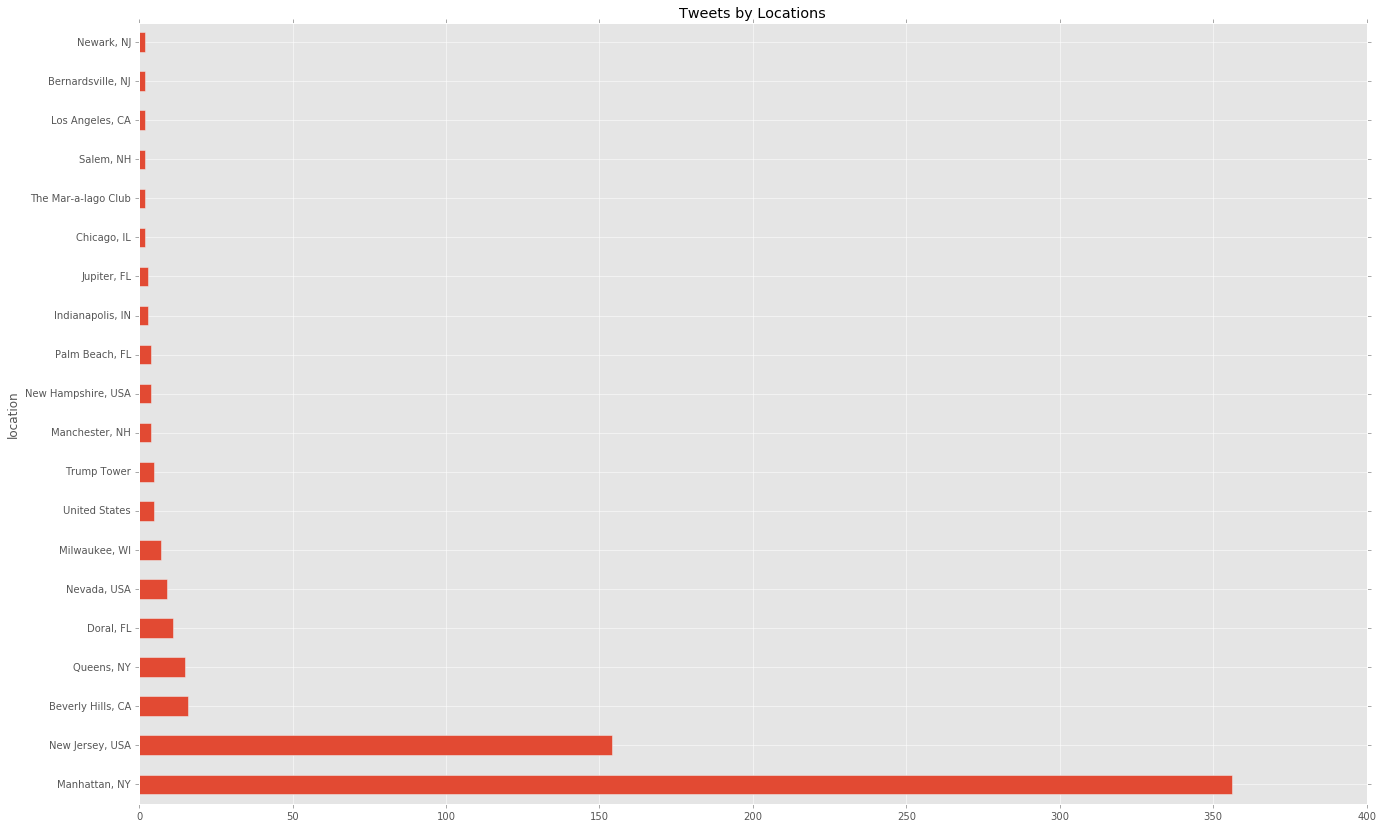

In [211]:
location = location.set_index('location')
location[:20].plot(kind='barh', title='Tweets by Locations', legend=False, figsize=(22,14))

## Hashtags

In [214]:
# # count

tags = []
for t in twits['tag']:
    if type(t) == str:
        tags.extend(t[1:-1].lower().split(', '))

tag = pd.DataFrame.from_dict(Counter(tags), orient = 'index').reset_index()
tag.columns = ['tag', 'count']
tag = tag.sort_values('count', ascending=False)
tag.reset_index(drop=True)[:20]

,tag,count
0,trump2016,536
1,makeamericagreatagain,417
2,votetrump,65
3,trump,52
4,gopdebate,40
5,demdebate,35
6,fitn,29
7,trumptrain,26
8,iacaucus,21
9,gop,19


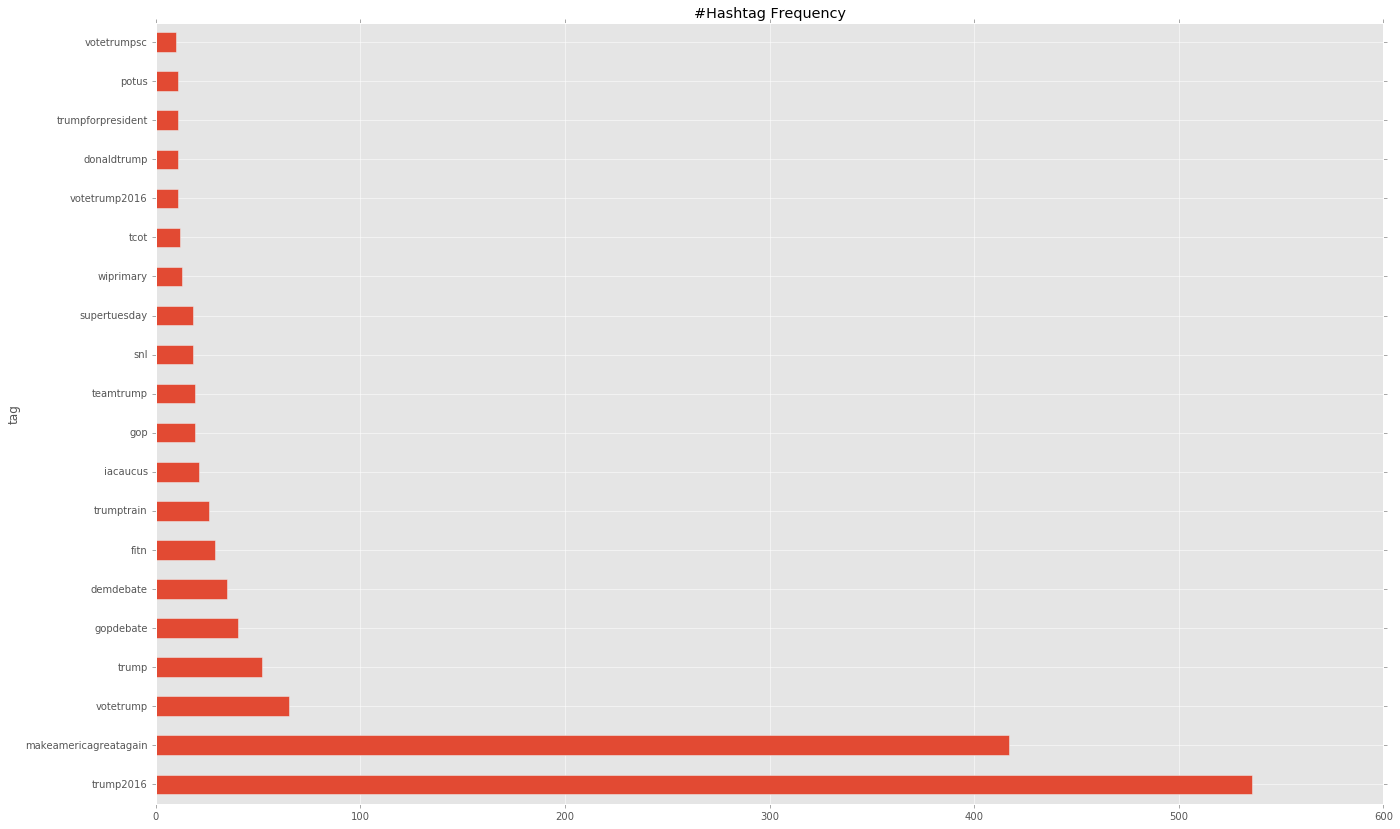

In [215]:
tag = tag.set_index('tag')
tag[:20].plot(kind='barh', title='#Hashtag Frequency', legend=False, figsize=(22,14))

## @'s

In [220]:
# @ count

ats = []
for a in twits['at']:
    if type(a) == str:
        ats.extend(a[1:-1].split(', '))

at = pd.DataFrame.from_dict(Counter(ats), orient='index').reset_index()
at.columns = ['at', 'count']
at = at.sort_values('count', ascending=False)
at = at.iloc[1:len(at['at']),:] # remove @realDonaldTrump
at.reset_index(drop=True)[:20]

,at,count
0,FoxNews,250
1,CNN,192
2,megynkelly,116
3,JebBush,76
4,seanhannity,72
5,foxandfriends,69
6,oreillyfactor,62
7,Macys,56
8,nytimes,48
9,KarlRove,44


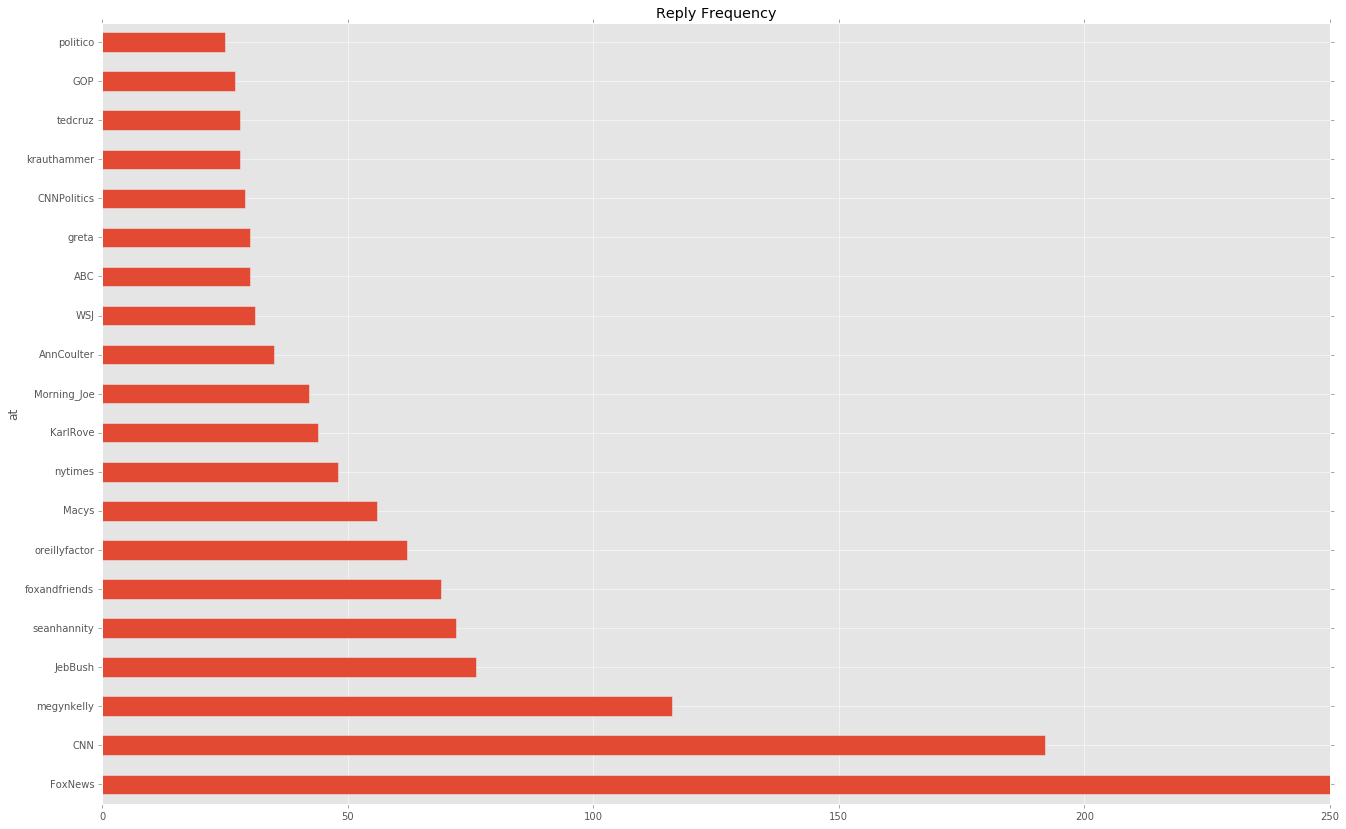

In [221]:
at = at.set_index('at')
at[:20].plot(kind='barh', title='Reply Frequency', legend=False, figsize=(22,14))


## Words

In [225]:
# word count
import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords")
stops = stopwords.words('english')

words = []
for w in twits['twit']:
    words.extend(w.lower().split())
words = [x for x in words if '@' not in x]
words = [x for x in words if '#' not in x]
words = map(lambda x: re.sub('[^A-Za-z0-9]+', '', x), words)
words = [x for x in words if x not in str(stops)]

word = pd.DataFrame.from_dict(Counter(words), orient='index').reset_index()
word.columns = ['word', 'count']
word = word.sort_values('count', ascending=False)
word.reset_index(drop=True)[:30]

,word,count
0,trump,1169
1,great,912
2,thank,648
3,america,454
4,donald,373
5,people,364
6,new,326
7,make,318
8,poll,276
9,like,256


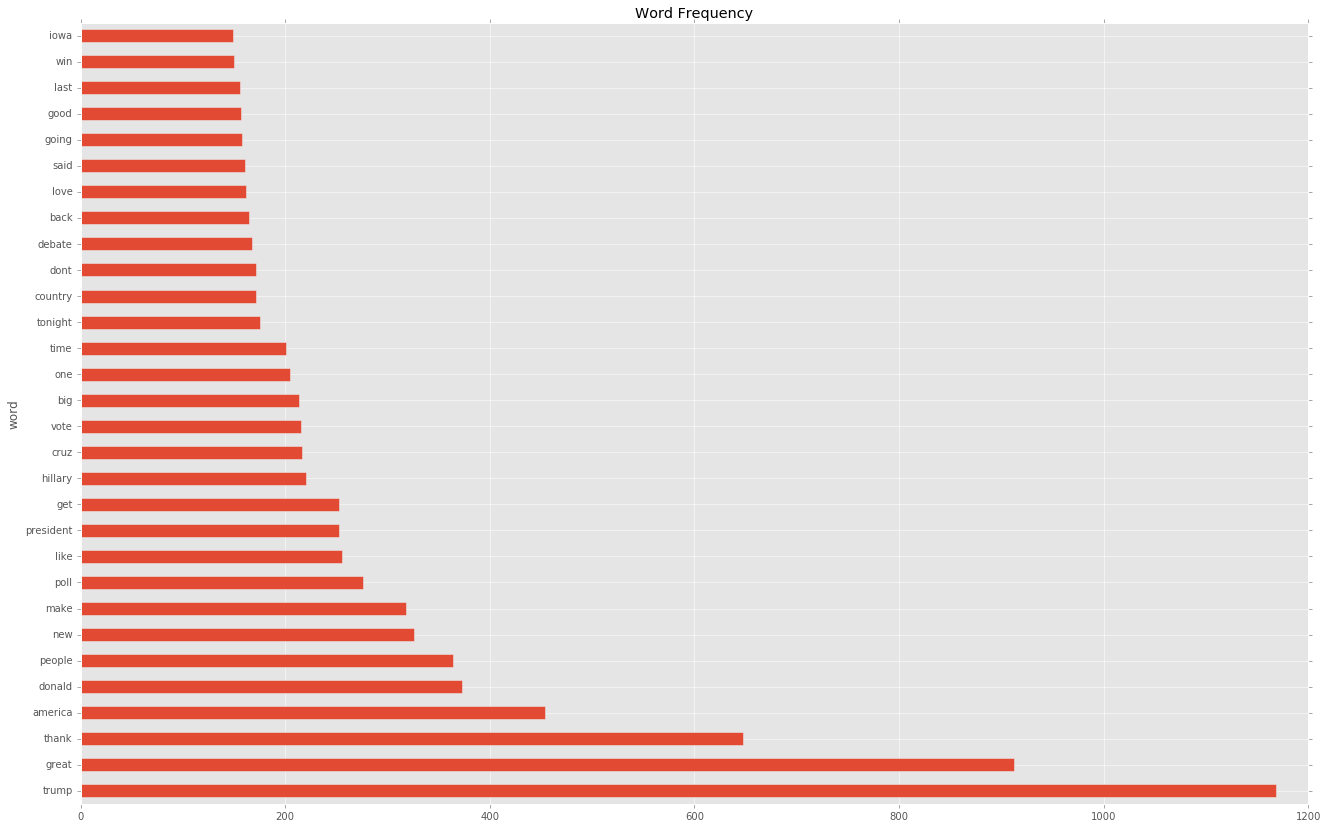

In [226]:
word = word.set_index('word')
word[:30].plot(kind='barh', title='Word Frequency', legend=False, figsize=(22,14))


# Conclusion

+ In about a year, Trump has grown the number of likes and retweets from under 50 to a couple thousand per tweet.
+ Most of Trump's tweets with location are from Manhattan and New Jersey.
+ Trump's 20 most frequent hashtags are political terms, with the exception of #SNL. #Trump2016 and #MakeAmericaGreatAgain are the top two.
+ Trump tweets at media the most, with the exception of Jeb Bush who is is 4th favorite Twitter buddy.
+ 'Trump' appears the most in the tweets, coming from articles and replies.
+ Twitter does not play nice after loading around 10,000 tweets.


# Improvements

+ Plot time series tweets to see progression over months
+ Sentiment analysis of Trump's tweets
+ Get #AskTrump tweets and find out what people think about Trump